# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%aimport transformations

transformations loaded, version: 0.1


In [3]:
df_data = t.from_pkl(f'{processed_data_path}/data_clean_3clusters.data.pkl')
df_data.shape
df_data.columns
df_data.head(3)

(8708128, 14)

Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status',
       'rpm_clusters'],
      dtype='object')

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status,rpm_clusters
6012,1,0,1,2.004000,-0.560106,0.244341,0.369884,0.663609,0.482786,0.653591,423.529412,0.382562,0,0
6013,1,0,1,2.004333,-0.848694,-0.134197,0.369884,1.041226,0.578898,0.653591,423.529412,0.102063,0,0
6014,1,0,1,2.004667,-0.271517,0.338975,0.081789,0.663609,0.578898,1.351112,423.529412,0.049370,0,0


In [4]:
df_data = df_data.loc[df_data['rpm_clusters'] == 1]

# Feature Engineering

In [5]:
df_data['a1_xyz'] = np.sqrt(   
    np.power(df_data['a1_x'], 2) + np.power(df_data['a1_y'], 2) + np.power(df_data['a1_z'], 2)
)

df_data['a2_xyz'] = np.sqrt(   
    np.power(df_data['a2_x'], 2) + np.power(df_data['a2_y'], 2) + np.power(df_data['a2_z'], 2)
)

df_data

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status,rpm_clusters,a1_xyz,a2_xyz
23994,1,0,1,7.998000,-0.271517,-0.228832,-3.663456,3.590142,-0.189997,-0.542160,1440.000000,0.944011,0,1,3.680624,3.635816
23995,1,0,1,7.998333,-0.560106,-0.512735,-1.742818,2.929312,-0.286109,-0.043930,1440.000000,0.481882,0,1,1.901060,2.943579
23996,1,0,1,7.998667,-1.810657,-0.985908,-0.494403,2.551695,0.002226,-0.143576,1440.000000,0.543777,0,1,2.120125,2.555732
23997,1,0,1,7.999000,-3.061209,-0.512735,-0.878530,1.135631,-0.286109,0.753237,1440.000000,0.609410,0,1,3.225789,1.392437
23998,1,0,1,7.999333,-4.696546,-0.985908,-1.934881,0.569205,0.290562,0.852882,1440.000000,0.655243,0,1,5.174295,1.065753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10226868,112,0,112,19.156000,1.460017,0.906782,0.946076,-2.168520,-2.112235,4.539780,1463.414634,0.136837,1,1,1.961877,5.456521
10226869,112,0,112,19.156333,0.882839,1.853127,0.561948,-2.262924,-0.862781,5.436593,1463.414634,0.242471,1,1,2.128208,5.951618
10226870,112,0,112,19.156667,-0.656302,2.515569,-1.166626,-1.696498,-0.862781,6.134114,1463.414634,0.347737,1,1,2.849532,6.422605
10226871,112,0,112,19.157000,0.017072,1.853127,-3.567424,-2.451733,-0.958893,5.934822,1463.414634,0.570670,1,1,4.020060,6.492502


In [6]:
def p01(arr):
    return np.quantile(arr, 0.05)

def p10(arr):
    return np.quantile(arr, 0.10)

def p20(arr):
    return np.quantile(arr, 0.20)

def p30(arr):
    return np.quantile(arr, 0.30)

def p99(arr):
    return np.quantile(arr, 0.99)

def p90(arr):
    return np.quantile(arr, 0.90)

def p80(arr):
    return np.quantile(arr, 0.80)

def p70(arr):
    return np.quantile(arr, 0.70)

def iqr(arr):
    return np.quantile(arr, 0.75) - np.quantile(arr, 0.25)

def kurtosis(series):
    return series.kurtosis()

def skew(series):
    return series.skew()

In [7]:
def grp_bearing(df, b_id):
    df_b_grp = df[['experiment_id', f'bearing_{b_id}_id', f'a{b_id}_x', f'a{b_id}_y', f'a{b_id}_z', f'a{b_id}_xyz', 'status']]\
        .groupby(['experiment_id', f'bearing_{b_id}_id', 'status'])\
        .agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, p01, p10, p20, p30, p99, p90, p80, p70, iqr, kurtosis, skew])

    df_b_grp.columns = ['__'.join(col).strip()[3:] for col in df_b_grp.columns]
    df_b_grp.reset_index(inplace = True)
    df_b_grp.rename({f'bearing_{b_id}_id': 'bearing_id'}, axis=1, inplace=True)
    return df_b_grp
    

In [8]:
df_b1 = grp_bearing(df_data, 1)
df_b1.shape
df_b1['status'].value_counts()

df_b2 = grp_bearing(df_data, 2)
df_b2.shape
df_b2['status'].value_counts()

(112, 75)

0    100
1     12
Name: status, dtype: int64

(112, 75)

0    100
1     12
Name: status, dtype: int64

In [9]:
df_b1 = pd.concat([
        df_b1.loc[df_b1['status']==1],
        df_b1.loc[df_b1['status']==0].sample(76, random_state=RS),
])
df_b1['status'] = 1

df_b1.shape
df_b1['status'].value_counts()

(88, 75)

1    88
Name: status, dtype: int64

In [10]:
df_train = pd.concat([
        df_b1,
        df_b2,
    ], axis=0, ignore_index=True)
df_train = df_train.sort_values(by='status').reset_index(drop=True)
df_train.shape
df_train['status'].value_counts()
df_train.columns

(200, 75)

0    100
1    100
Name: status, dtype: int64

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__p01', 'x__p10',
       'x__p20', 'x__p30', 'x__p99', 'x__p90', 'x__p80', 'x__p70', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__p01', 'y__p10', 'y__p20', 'y__p30',
       'y__p99', 'y__p90', 'y__p80', 'y__p70', 'y__iqr', 'y__kurtosis',
       'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median', 'z__mean',
       'z__std', 'z__var', 'z__p01', 'z__p10', 'z__p20', 'z__p30', 'z__p99',
       'z__p90', 'z__p80', 'z__p70', 'z__iqr', 'z__kurtosis', 'z__skew',
       'xyz__amin', 'xyz__amax', 'xyz__sum', 'xyz__median', 'xyz__mean',
       'xyz__std', 'xyz__var', 'xyz__p01', 'xyz__p10', 'xyz__p20', 'xyz__p30',
       'xyz__p99', 'xyz__p90', 'xyz__p80', 'xyz__p70', 'xyz__iqr',
       'xyz__kurtosis', 'xyz__skew'],
      dtype='object')

In [11]:
df_plt = df_train
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

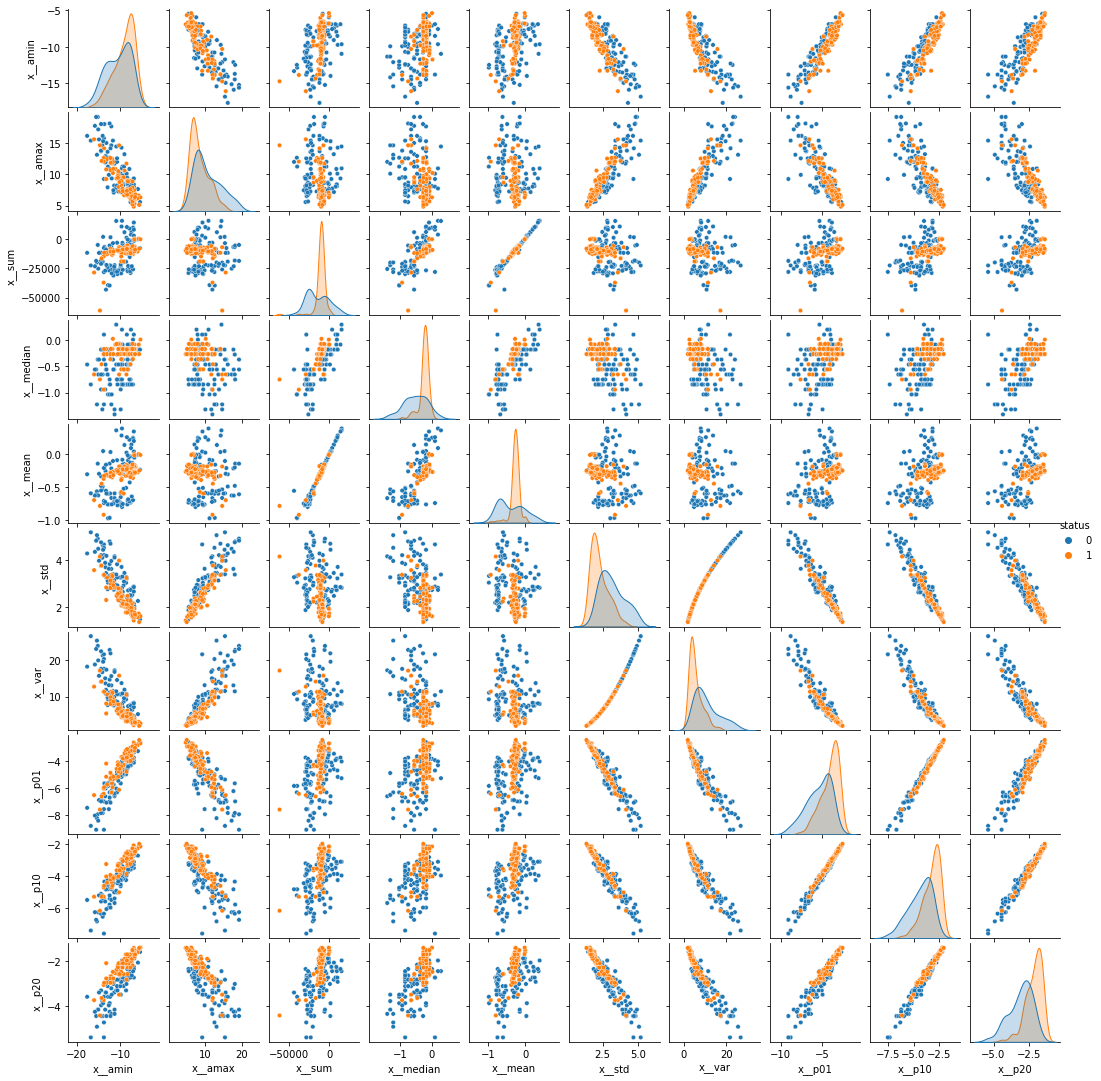

In [12]:
_ = sns.pairplot(data=df_plt, vars = cols[:10], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

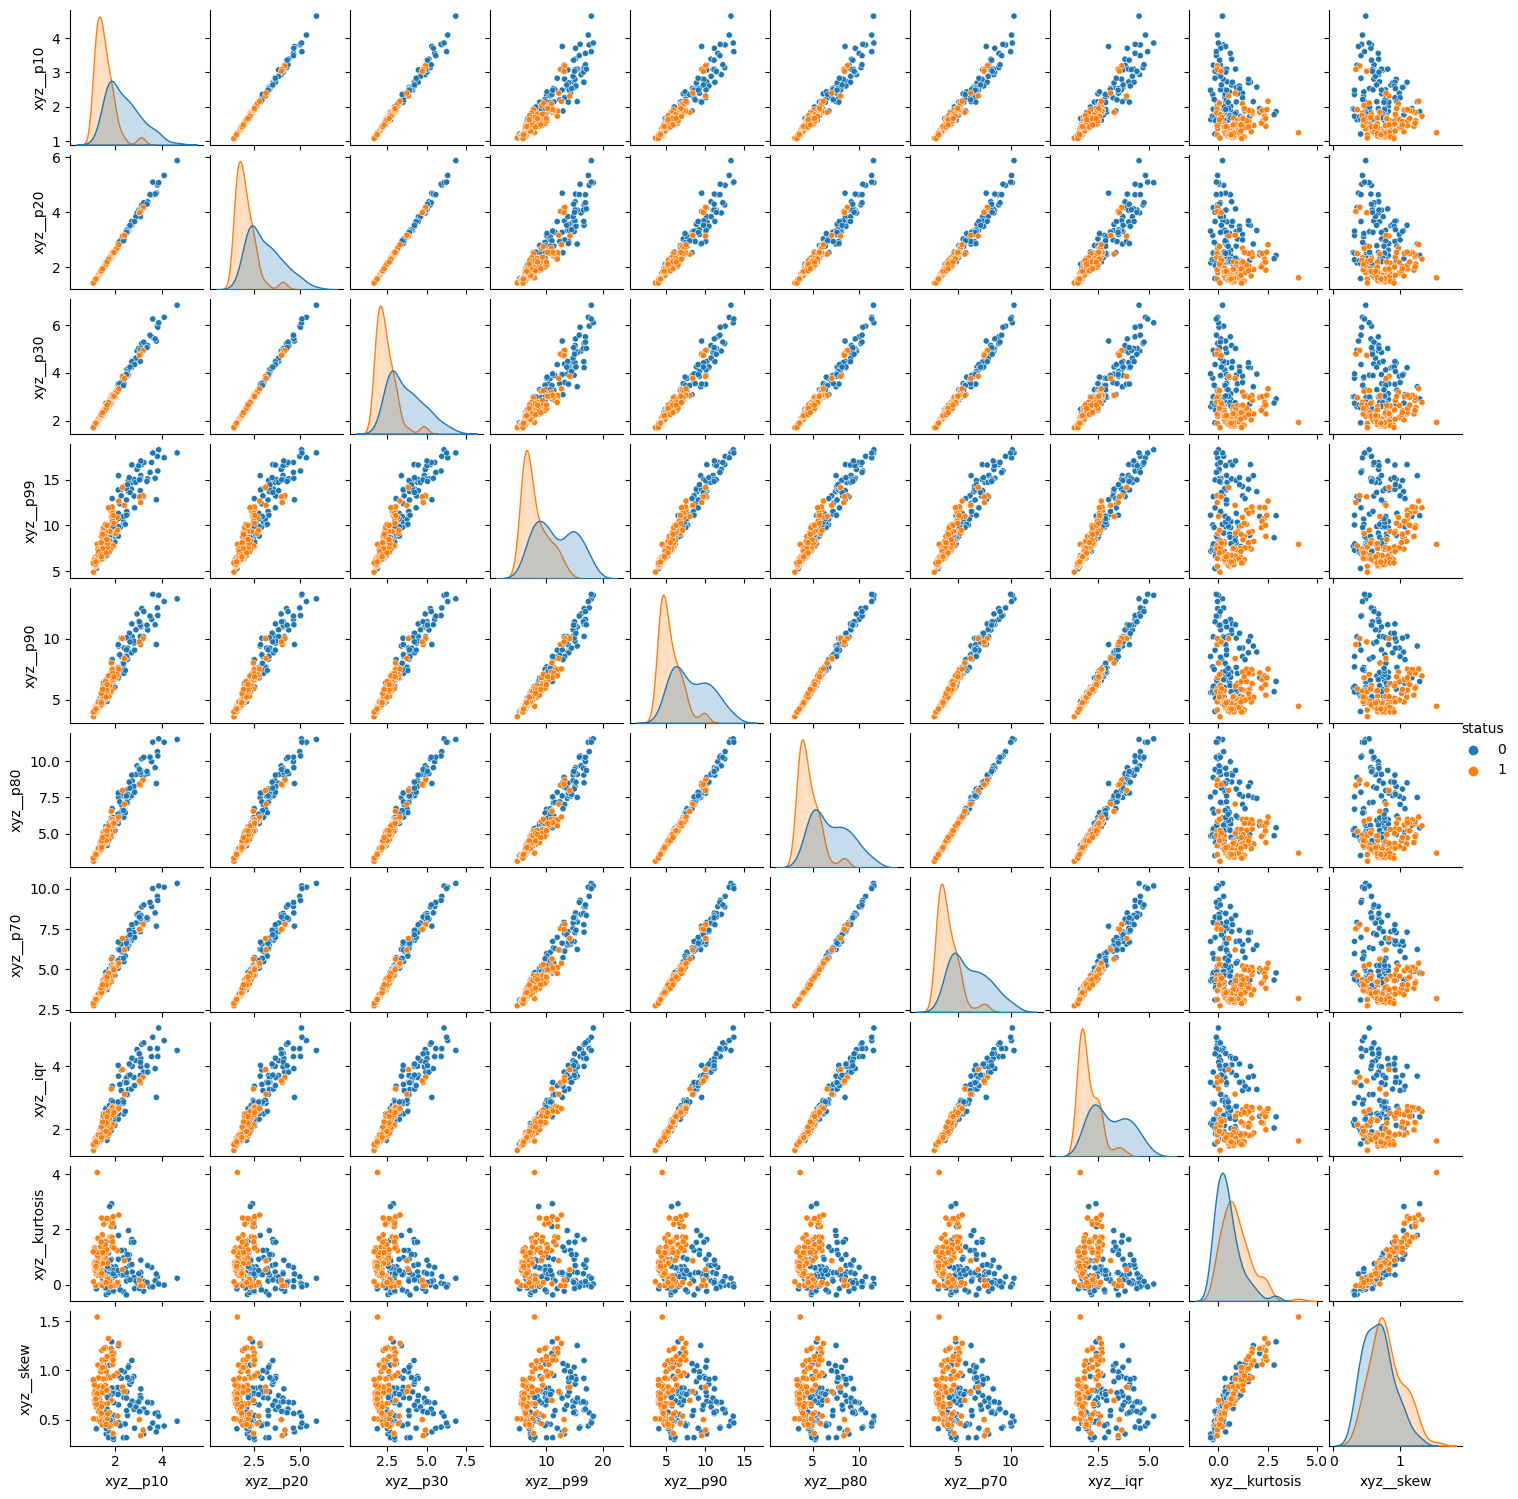

In [13]:
_ = sns.pairplot(data=df_plt, vars = cols[-10:], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

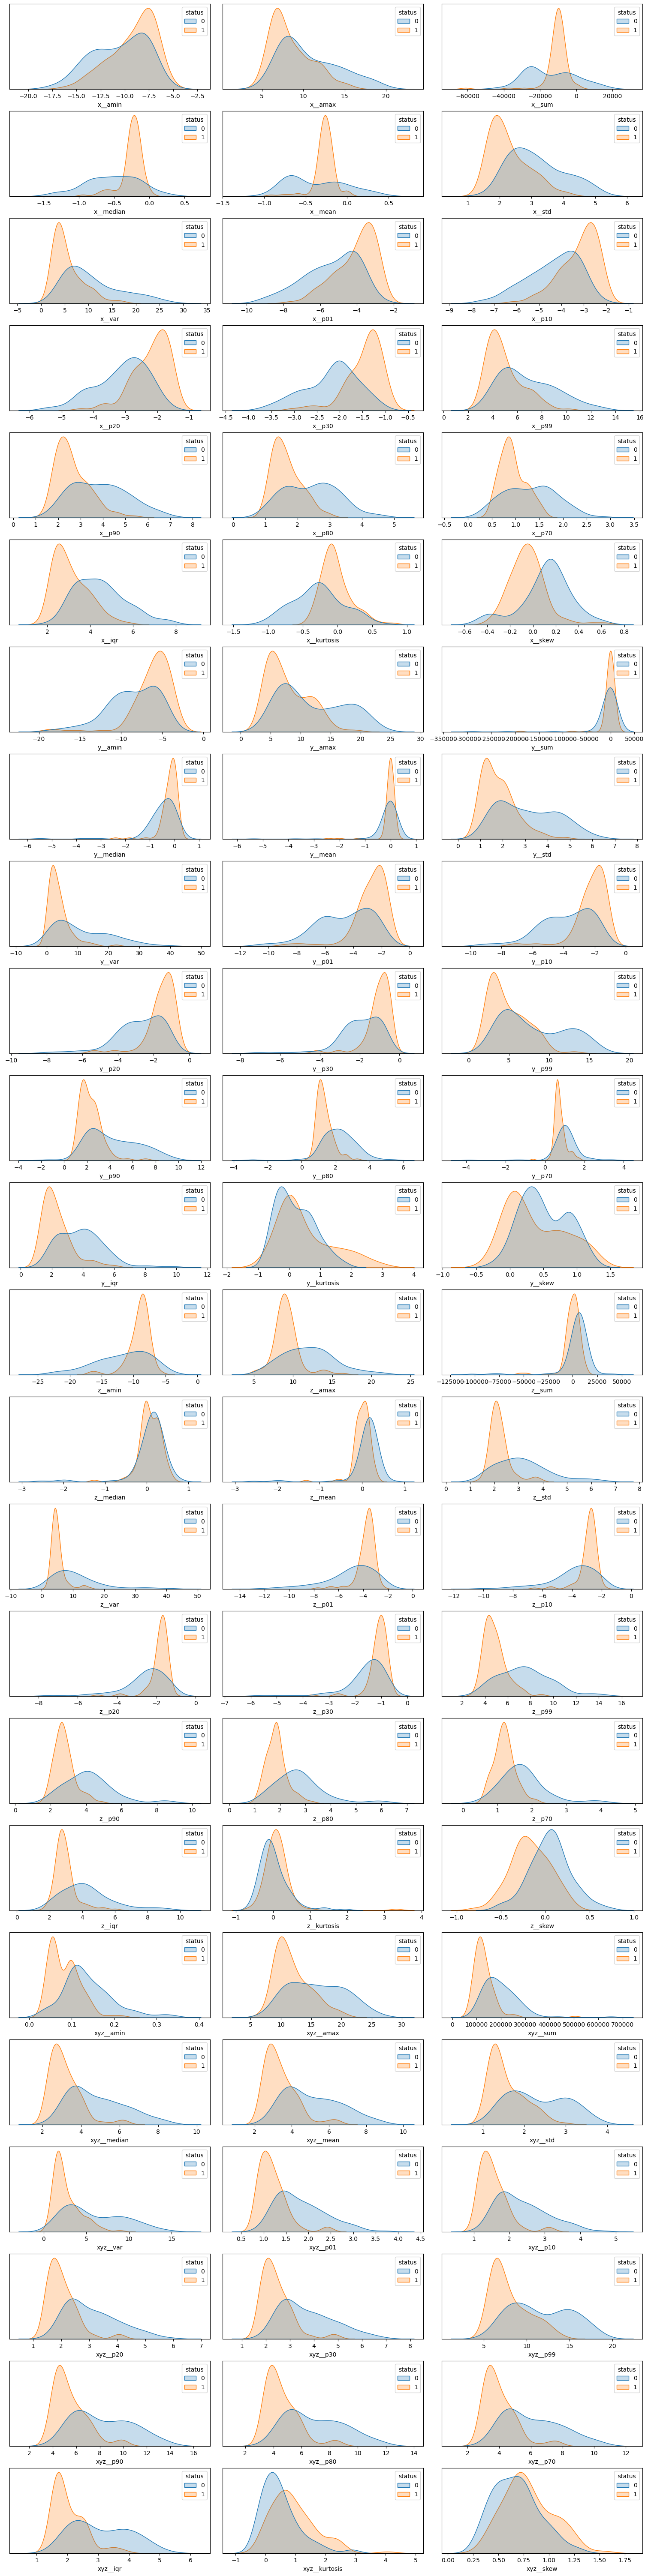

In [14]:
df_plt = df_train
# cols = ['x__amin', 'x__amax', 'x__sum','y__amin', 'y__amax', 'y__sum', 'z__amin', 'z__amax', 'z__sum']
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

axs = t.get_axes(int(len(cols)/3), 3, 1/2)

for col, ax in zip(cols, axs.flat):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', shade=True)
    # _ = ax.axes.get_xaxis().set_visible(False)
    _ = ax.axes.get_yaxis().set_visible(False)
    # _ = ax.legend().set_visible(False)

In [15]:
df_train.columns
feature_cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

X = df_train[feature_cols]
X.shape
X.head(3)

y = df_train['status']
y.shape
y.head(3)

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__p01', 'x__p10',
       'x__p20', 'x__p30', 'x__p99', 'x__p90', 'x__p80', 'x__p70', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__p01', 'y__p10', 'y__p20', 'y__p30',
       'y__p99', 'y__p90', 'y__p80', 'y__p70', 'y__iqr', 'y__kurtosis',
       'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median', 'z__mean',
       'z__std', 'z__var', 'z__p01', 'z__p10', 'z__p20', 'z__p30', 'z__p99',
       'z__p90', 'z__p80', 'z__p70', 'z__iqr', 'z__kurtosis', 'z__skew',
       'xyz__amin', 'xyz__amax', 'xyz__sum', 'xyz__median', 'xyz__mean',
       'xyz__std', 'xyz__var', 'xyz__p01', 'xyz__p10', 'xyz__p20', 'xyz__p30',
       'xyz__p99', 'xyz__p90', 'xyz__p80', 'xyz__p70', 'xyz__iqr',
       'xyz__kurtosis', 'xyz__skew'],
      dtype='object')

(200, 72)

,x__amin,x__amax,x__sum,x__median,x__mean,x__std,x__var,x__p01,x__p10,x__p20,x__p30,x__p99,x__p90,x__p80,x__p70,x__iqr,x__kurtosis,x__skew,y__amin,y__amax,y__sum,y__median,y__mean,y__std,y__var,y__p01,y__p10,y__p20,y__p30,y__p99,y__p90,y__p80,y__p70,y__iqr,y__kurtosis,y__skew,z__amin,z__amax,z__sum,z__median,z__mean,z__std,z__var,z__p01,z__p10,z__p20,z__p30,z__p99,z__p90,z__p80,z__p70,z__iqr,z__kurtosis,z__skew,xyz__amin,xyz__amax,xyz__sum,xyz__median,xyz__mean,xyz__std,xyz__var,xyz__p01,xyz__p10,xyz__p20,xyz__p30,xyz__p99,xyz__p90,xyz__p80,xyz__p70,xyz__iqr,xyz__kurtosis,xyz__skew
0,-9.060034,13.219381,5575.268706,-0.563647,0.138923,3.451476,11.912683,-4.623032,-3.867797,-2.829350,-1.979711,8.971188,5.100611,3.306930,1.702056,5.003428,-0.192928,0.565319,-10.377857,19.224603,-1121.855887,-0.862781,-0.027954,4.319935,18.661842,-5.764487,-4.418920,-3.073354,-2.208347,13.650114,6.153387,2.405023,0.771121,4.036699,1.695384,1.177432,-11.303914,10.119949,5642.467250,0.255007,0.140598,2.641637,6.978244,-4.527995,-3.332244,-1.937202,-1.040389,6.134114,3.443675,2.247925,1.450758,3.288314,0.296101,-0.239643,0.101637,20.677288,213328.235738,4.599702,5.315664,3.055426,9.335629,1.647387,2.149269,2.845009,3.417773,15.440481,9.415559,7.505481,6.231770,3.689047,1.778544,1.252817
1,-12.080972,17.656383,-6971.401465,-0.186030,-0.217442,3.621519,13.115403,-6.227905,-4.811840,-3.206967,-2.074116,8.215953,4.345377,2.740504,1.702056,4.814619,0.337405,0.064638,-11.819535,20.281834,-1591.550244,-0.670557,-0.049641,4.917875,24.185490,-7.494501,-5.764487,-3.650025,-2.496683,14.803456,6.826170,3.173918,1.347793,5.093930,1.031732,0.809109,-10.805685,12.411804,5708.853653,0.055715,0.178062,3.210280,10.305895,-4.926578,-3.930120,-2.535077,-1.638264,7.927740,4.440134,2.945446,1.849341,4.484064,-0.211116,0.193339,0.183889,21.508638,197140.126797,5.549111,6.148908,3.142928,9.877998,2.141077,2.713837,3.526174,4.216413,16.653496,10.205893,8.513351,7.304506,4.001074,1.633724,1.100826
2,-13.685845,18.034001,-6932.965833,-0.280434,-0.203492,3.384346,11.453795,-5.661479,-4.339819,-3.018159,-1.979711,7.838336,4.062164,2.551695,1.513248,4.437002,0.350866,0.118662,-11.819535,18.936267,-1257.606062,-0.286109,-0.036912,3.805050,14.478407,-5.860599,-4.515032,-3.073354,-2.112235,10.958981,4.519485,2.981695,1.732240,4.901706,1.243051,0.478897,-14.093999,12.710742,4560.664303,-0.043930,0.133862,3.328529,11.079107,-4.926578,-3.930120,-2.634723,-1.737910,8.027385,4.539780,2.945446,1.849341,4.583710,0.144280,0.100333,0.044074,22.153908,187515.519048,5.105773,5.503831,2.603643,6.778957,2.027236,2.572454,3.335038,3.947068,13.695016,8.919087,7.440800,6.493121,3.262636,1.956811,1.047196


(200,)

0    0
1    0
2    0
Name: status, dtype: int64

In [16]:
t.to_pkl((X, y), f'{processed_data_path}/all_b1_b2_xyz_distance_cluster1.data.pkl', True)